In [1]:
import utilities as ut
from pudb import set_trace
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from pytorch_lightning.loggers import TensorBoardLogger
import os
from net import IDENet
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from multiprocessing import Pool, cpu_count
import pysam
import time
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.suggest import Repeater
from ray.tune.schedulers import ASHAScheduler, PopulationBasedTraining
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.integration.pytorch_lightning import TuneReportCallback, \
    TuneReportCheckpointCallback
import list2img
from hyperopt import hp
from sklearn.metrics import classification_report


In [2]:
data_dir = "/home/xwm/DeepSVFilter/code_BIBM/"
config = {
    "lr": 7.1873e-06,
    "batch_size": 118, # 14,
    "beta1": 0.9,
    "beta2": 0.999,
    'weight_decay': 0.0011615,
    # "classfication_dim_stride": 20, # no use
}

In [20]:
model = IDENet.load_from_checkpoint(
    "/home/xwm/DeepSVFilter/code_BIBM/checkpoints_predict/4channel_predict_del/epoch=10-validation_mean=0.91-train_mean=0.92.ckpt",
    path = data_dir, config = config)

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
trainer = pl.Trainer(gpus=1)
model.eval()
result = trainer.test(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'validation_loss': 0.17735622823238373,
 'validation_loss_epoch': 0.17735622823238373}
--------------------------------------------------------------------------------


In [22]:
output = torch.load("test_output.pt")

y = torch.empty(0, 2)
y_hat = torch.empty(0, 2).cuda()


for out in output:
    for ii in out['y']:
        if ii == 0:
            y = torch.cat([y, torch.tensor([1, 0]).unsqueeze(0)], 0)
        else:
            # y[i] = 1
            y = torch.cat([y, torch.tensor([0, 1]).unsqueeze(0)], 0)
    y_hat = torch.cat([y_hat, out['y_hat']], 0)

/home/xwm/anaconda3/envs/SV/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


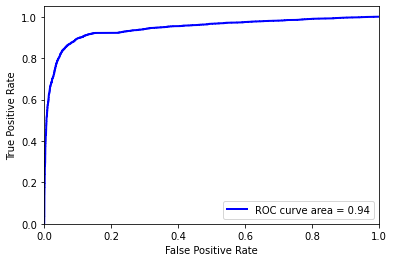

In [45]:
# 引入必要的库
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# 加载数据
y_test = y.cpu().numpy()
y_score = y_hat.cpu().numpy()
# 设置种类
n_classes = y.shape[1]

# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure()

i = 1
color = 'blue'
plt.plot(fpr[i], tpr[i], color=color, lw=lw,
         label='ROC curve area = {1:0.2f}'
         ''.format(i, roc_auc[i]))
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig("del_roc.pdf", dpi=1000, bbox_inches = 'tight')
plt.show()


In [24]:
metric = classification_report(torch.argmax(y.cpu(), dim = 1), torch.argmax(y_hat.cpu(), dim = 1), output_dict = True)

In [25]:
print(classification_report(torch.argmax(y.cpu(), dim = 1), torch.argmax(y_hat.cpu(), dim = 1), digits=4))

              precision    recall  f1-score   support

           0     0.9298    0.9334    0.9316      8444
           1     0.8629    0.8560    0.8594      4131

    accuracy                         0.9080     12575
   macro avg     0.8963    0.8947    0.8955     12575
weighted avg     0.9078    0.9080    0.9079     12575



In [26]:
metric["accuracy"]

0.9079920477137177

In [27]:
metric["macro avg"]

{'precision': 0.8963350029963661,
 'recall': 0.8947054718279519,
 'f1-score': 0.8955115552778347,
 'support': 12575}

In [28]:
metric["0"]

{'precision': 0.9298100743187449,
 'recall': 0.9334438654666035,
 'f1-score': 0.9316234265114355,
 'support': 8444}

In [29]:
metric["1"]

{'precision': 0.8628599316739873,
 'recall': 0.8559670781893004,
 'f1-score': 0.8593996840442338,
 'support': 4131}